In [22]:
import random
import numpy as np
from time import time
import inspyred
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

In [3]:
def create_lamp_grid(grid_size, problem_size):
    da = 1/ grid_size
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    N = int(r * grid_size)
    lamp_grid = np.zeros((2*N+1, 2*N+1))
    for i in range(2*N+1):
        for j in range(2*N+1):
            x = (i-N) * da
            y = (j-N) * da
            if x**2 + y**2 <= r2:
                lamp_grid[i,j] = 1
    return lamp_grid

In [4]:
# Function to calculate the enlightened and overlap area
def calculate_areas(lamps, grid_size, problem_size, lamp_grid):
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    rN = lamp_grid.shape[0]
    extra = rN // 2
    # Initialize the grid
    tot_grid = np.zeros((grid_size + 2 * extra, grid_size + 2 * extra))
    
    # Illuminate the grid with each lamp
    for x, y in lamps:
        # Calculate the index of the lamp in the grid
        x_min = max(0, int(x * grid_size)-1)
        y_min = max(0, int(y * grid_size)-1)
        tot_grid[x_min:x_min+rN, y_min:y_min+rN] += lamp_grid

    # Remove the extra rows and columns
    tot_grid = tot_grid[extra:-extra, extra:-extra]
    # Count the enlightened and overlap area
    enlightened_area = np.sum(tot_grid > 0) / grid_size**2
    overlap_area = 1 / problem_size * len(lamps) - enlightened_area

    return enlightened_area, overlap_area

In [5]:
test_N = 3000
mat = create_lamp_grid(test_N, 3)
mat.shape

(1955, 1955)

In [6]:
lamps = [(0.25, 0.25), (0.75, 0.75), (0.25, 0.75), (0.75, 0.25)]
enlightened_area, overlap_area = calculate_areas(lamps, test_N, 3, mat)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.9872208888888889
Overlap area: 0.34611244444444433


In [7]:
# The Evaluator
def evaluator_lamp(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    weight_overlap = args.get('weight_overlap', 1)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, overlap_area = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append((enlightened_area - weight_overlap * overlap_area))
    return fitness

In [8]:
# The Generator
def generator_lamp(random, args):
    problem_size = args.get('problem_size')
    number_lamps = random.randint(problem_size, problem_size*3)
    return [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(number_lamps)] 

In [9]:
# The Bounder
def bound_lamp(candidate, args):
    for i, c in enumerate(candidate):
        x = max(min(c[0], 1), 0)
        y = max(min(c[1], 1), 0)
        candidate[i] = (x, y)
    return candidate
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [10]:
# The Observer
def observer_lamp(population, num_generations, num_evaluations, args):
    avg_len = np.mean([len(c.candidate) for c in population])
    best = max(population)
    print('{0:6} -- {1} : {2}'.format(num_generations, best.fitness, avg_len))

In [36]:
# Custom mutation operator
def mutate_lamp(random, candidates, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    problem_size = args.get('problem_size')
    bounder = args['_ec'].bounder
    for i, cs in enumerate(candidates):
        for j, (c, lo, hi) in enumerate(zip(cs, bounder.lower_bound, bounder.upper_bound)):
            if random.random() < mut_rate:
                xi = random.random()
                if xi < 0.5:
                    # Change the position of the lamp
                    x = c[0] + random.gauss(0, 0.1) * (hi - lo)
                    y = c[1] + random.gauss(0, 0.1) * (hi - lo)
                    candidates[i][j] = (x, y)
                elif xi < 0.75 and len(cs) < 3 * problem_size:
                    # Add a new lamp
                    cs.append((random.uniform(0, 1), random.uniform(0, 1)))
                elif len(cs) > problem_size:
                    # Remove a lamp
                    index = random.randint(0, len(cs)-1)
                    del cs[index]
        candidates[i] = bounder(candidates[i], args)
    return candidates

In [29]:
# Custom crossover operator
def crossover_lamp(random, mom, dad, args):
    crossover_rate = args.setdefault('crossover_rate', 1.0)
    children = []
    
    if random.random() < crossover_rate:
        bro = copy.copy(dad)
        sis = copy.copy(mom)
        length = min(len(mom), len(dad))
        index = random.randint(0, length-1)
        child1 = bro[:index] + sis[index:]
        child2 = sis[:index] + bro[index:]
        children.append(child1)
        children.append(child2)
    else:
        children.append(mom)
        children.append(dad)
    return children

In [42]:
def my_crossover(random, candidates, args):
    if len(candidates) % 2 == 1:
        candidates = candidates[:-1]
    moms = candidates[::2]
    dads = candidates[1::2]
    children = []
    for i, (mom, dad) in enumerate(zip(moms, dads)):
        crossover_lamp.index = i
        offspring = crossover_lamp(random, mom, dad, args)
        for o in offspring:
            children.append(o)
    return children

In [94]:
rand = random.Random()
rand.seed(39)
my_ec = inspyred.ec.EvolutionaryComputation(rand)
#my_ec.selector = inspyred.ec.selectors.tournament_selection
my_ec.variator = [my_crossover, 
                  mutate_lamp]
my_ec.replacer = inspyred.ec.replacers.plus_replacement
my_ec.observer = observer_lamp
my_ec.terminator = [inspyred.ec.terminators.evaluation_termination
                    ,inspyred.ec.terminators.average_fitness_termination]

In [95]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [107]:
final_pop = my_ec.evolve(generator = generator_lamp,
                         evaluator = evaluator_lamp,
                         pop_size = 100,
                         bounder = bound_lamp,
                         max_evaluations = 5000,
                         num_selected = 50,
                         crossover_rate = 1,
                         mutation_rate = 0.5,
                         # Custom args
                         problem_size = problem_size,
                         grid_size = grid_size,
                         lamp_grid = lamp_grid,
                         weight_overlap = 1)
print('Terminated due to {0}.'.format(my_ec.termination_cause))
final_pop.sort(reverse=True)
print(final_pop[0])

     0 -- 0.3660835555555553 : 9.41
     1 -- 0.47890311111111106 : 6.83
     2 -- 0.5713306666666667 : 6.05
     3 -- 0.5713306666666667 : 5.58
     4 -- 0.5713306666666667 : 5.48
     5 -- 0.5713306666666667 : 5.38
     6 -- 0.5713306666666667 : 5.32
     7 -- 0.5713306666666667 : 5.3
     8 -- 0.5713306666666667 : 5.27
     9 -- 0.5713306666666667 : 5.23
    10 -- 0.5713306666666667 : 5.18
    11 -- 0.5713306666666667 : 5.16
    12 -- 0.5713306666666667 : 5.12
    13 -- 0.6023964444444445 : 5.11
    14 -- 0.6023964444444445 : 5.12
    15 -- 0.6023964444444445 : 5.11
    16 -- 0.6023964444444445 : 5.08
    17 -- 0.6085013333333333 : 5.09
    18 -- 0.6085013333333333 : 5.09
    19 -- 0.6085013333333333 : 5.1
    20 -- 0.6085013333333333 : 5.09
    21 -- 0.616111111111111 : 5.07
    22 -- 0.6465564444444445 : 5.06
    23 -- 0.6465564444444445 : 5.05
    24 -- 0.6465564444444445 : 5.05
    25 -- 0.6465564444444445 : 5.05
    26 -- 0.6465564444444445 : 5.04
    27 -- 0.6465564444444445 :

In [116]:
def plot_lamps(candidate, problem_size):
    fig, ax = plt.subplots(figsize=(6, 6))
    # ax.axis('off')  # turn off the axis
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # plot the best candidate
    radius = np.sqrt(1 / problem_size / np.pi)
    for (x, y) in candidate: 
        circle = patches.Circle((x, y), radius, edgecolor='b', facecolor='none')
        ax.add_patch(circle)
        ax.plot(x, y, 'ro')

    plt.savefig('lamp_positions.png')

In [117]:
# Calculate the number of length of final population
D = {}
for f in final_pop:
    if len(f.candidate) in D:
        D[len(f.candidate)] += 1
    else:
        D[len(f.candidate)] = 1
print(D)

{5: 100}


In [118]:
enlightened_area, overlap_area = calculate_areas(final_pop[0].candidate, grid_size, problem_size, lamp_grid)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.855668
Overlap area: 0.14433200000000002


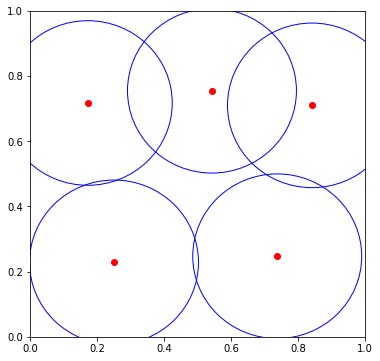

In [119]:
plot_lamps(final_pop[0].candidate, problem_size)

## Multi-Objective

In [120]:
# The Evaluator
def evaluator_lamp_multi_objective(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, _ = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append(inspyred.ec.emo.Pareto( [-len(candidate), enlightened_area] ))
    return fitness

In [121]:
rand = random.Random()
rand.seed(39)
nsga2 = inspyred.ec.emo.NSGA2(rand)
nsga2.terminator = inspyred.ec.terminators.evaluation_termination
nsga2.variator = [my_crossover, 
                  mutate_lamp]
nsga2.observer = observer_lamp

In [122]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [123]:
final_pareto_front = nsga2.evolve(generator = generator_lamp,
                                  evaluator = evaluator_lamp_multi_objective,
                                  pop_size = 100,
                                  bounder = bound_lamp,
                                  max_evaluations = 5000,
                                  num_selected = 100,
                                  crossover_rate = 1,
                                  mutation_rate = 0.8,
                                  # Custom args
                                  problem_size = problem_size,
                                  grid_size = grid_size,
                                  lamp_grid = lamp_grid)
print('Terminated due to {0}.'.format(nsga2.termination_cause))

     0 -- [-6, 0.7238364444444444] : 8.92
     1 -- [-11, 0.9480417777777778] : 9.28
     2 -- [-11, 0.9480417777777778] : 9.41
     3 -- [-11, 0.9480417777777778] : 9.63
     4 -- [-11, 0.9480417777777778] : 9.67
     5 -- [-11, 0.9480417777777778] : 9.66
     6 -- [-11, 0.9480417777777778] : 9.67
     7 -- [-7, 0.8904146666666667] : 9.69
     8 -- [-7, 0.8904146666666667] : 9.69
     9 -- [-7, 0.8904146666666667] : 9.68
    10 -- [-7, 0.8904146666666667] : 9.55
    11 -- [-7, 0.8904146666666667] : 9.65
    12 -- [-7, 0.8904146666666667] : 9.69
    13 -- [-7, 0.8904146666666667] : 9.73
    14 -- [-7, 0.8904146666666667] : 9.69
    15 -- [-6, 0.8646773333333333] : 9.73
    16 -- [-6, 0.8646773333333333] : 9.69
    17 -- [-6, 0.8646773333333333] : 9.72
    18 -- [-6, 0.8646773333333333] : 9.72
    19 -- [-6, 0.8646773333333333] : 9.72
    20 -- [-6, 0.8646773333333333] : 9.74
    21 -- [-6, 0.8646773333333333] : 9.75
    22 -- [-6, 0.8646773333333333] : 9.76
    23 -- [-6, 0.86467733333

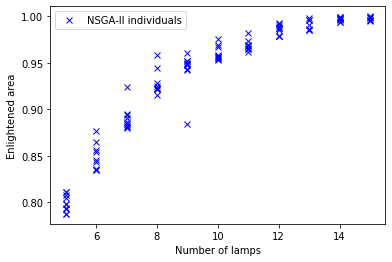

In [131]:
x_nsga2 = [ -individual.fitness[0] for individual in final_pareto_front ]
y_nsga2 = [ individual.fitness[1] for individual in final_pareto_front ]
plt.plot(x_nsga2, y_nsga2, 'bx', label="NSGA-II individuals")
plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

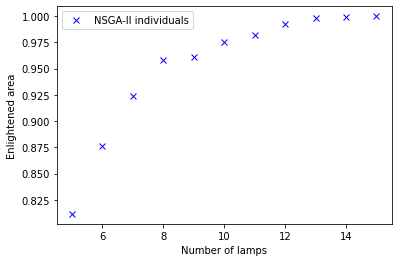

In [132]:
# Select the best individual for each number of lamps
D = {}
for f in final_pareto_front:
    N = len(f.candidate) 
    if N in D:
        if D[N].fitness[1] < f.fitness[1]:
            D[N] = f
    else:
        D[N] = f
x_best = [ -individual.fitness[0] for individual in D.values() ]
y_best = [ individual.fitness[1] for individual in D.values() ]
plt.plot(x_best, y_best, 'bx', label="NSGA-II individuals")
plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

## Parisian Evolution

For the lamps problem, the PE has been implemented as follows. An individual represents a lamp, its genome is its $(x, y)$ position, plus a third element, $e$, that can assume values 0 or 1 (on/off switch). Lamps with $e=1$ are "on" (expressed) and contribute to the global solution, while lamps with $e=0$ do not.

In [133]:
# The PE generator
def PE_generator(random, args):
    return [random.uniform(0, 1), random.uniform(0, 1), random.randint(0, 1)]

In [134]:
# The Bounder
def PE_bound(candidate, args):
    x = max(min(candidate[0], 1), 0)
    y = max(min(candidate[1], 1), 0)
    z = max(min(candidate[2], 1), 0)
    z = round(z)
    return [x, y, z]
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [ ]:
# The Selector
